# Project 2
### 4/5 perfect solutions required for full score

These exercises should be done on a computer using Python. 	Please submit a Jupyter-notebook, containing both your code and the report in the same file. Provide properly commented code.

Some of the tasks involve sparse matrices, to obtain efficient code it is preferable to work with sparse matrices using for example the library `sparse` of  `scipy`. In these exercises you are allowed to work with full matrices if you find it easier, but make sure that the comparisons of the various methods in your implementations, e.g. when comparing running times, are fair. Be explicit about these issues in your report.

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt

# 1 Linear systems -Poisson equation-
We are going to numerically solve the following equation for $(x,y)\in [0,1]^2$ with the Dirichlet boundary condition:
	$$
	u_{xx} + u_{yy}= f, \text{and} \;\; u=0 {\text{ for boundary}} 
	$$
    where $u_{xx}$ and $u_{yy}$ are the second order partial derivatives of the unknown function $u(x,y)$, and $f(x,y)$ is a given function. We discretize the above problem on the regular equispaced grid: $x_i=\frac{i}{n+1}$,  and $y_j=\frac{j}{n+1}$  with $i,j=1,...,n$ ($0$ and $n+1$ correspond to the boundary). 
    We use the following finite difference approximation
    $$u_{xx}(x_i,y_j)+u_{yy}(x_i,y_j)\approx\frac{u(x_{i+1},y_j)-2u(x_{i},y_j)+u(x_{i-1},y_j)}{(\Delta x)^2} +\frac{u(x_i,y_{j+1})-2u(x_{i},y_{j})+u(x_i,y_{j-1})}{(\Delta y)^2}.$$
Note that we have $\Delta x=\Delta y=1/(n+1)$ here. Thus we consider the following linear system to approximate the above problem 
	$$
	\frac{1}{(\Delta x)^2}A \mathbf{u}  = \mathbf{f},
	$$
where the left hand side is a finite-difference discretization of $u_{xx} + u_{yy}$, the matrix $A$ is implemented in the code below, and $\mathbf{f}$ is the discretized vector of function $\mathbf{f}=(f(x_1,y_1),f(x_2,y_1),...,f(x_n,y_1),f(x_1,y_2),...,f(x_n,y_2),....,f(x_n,y_n))^{\top}$, as well as $\mathbf{u}=(u(x_1,y_1),u(x_2,y_1),...,u(x_n,y_1),u(x_1,y_2),...,u(x_n,y_2),....,u(x_n,y_n))^{\top}$. 

In [3]:
from scipy import sparse
from scipy import linalg
from scipy.sparse.linalg import eigs

# Creating the matrix A for n=10
n = 10
nx, ny = n, n
m = nx*ny # number of x_i, y_i pairs
main_diag = np.ones(m)*-4.0
side_diag = np.ones(m-1)
side_diag[np.arange(1,m)%nx==0] = 0
side_diag2 = np.ones(m-nx)
diagonals = [main_diag,side_diag,side_diag,side_diag2,side_diag2]
Amatrix = sparse.diags(diagonals, [0, -1, 1,nx,-(nx)])

print(Amatrix @ np.identity(m))


[[-4.  1.  0. ...  0.  0.  0.]
 [ 1. -4.  1. ...  0.  0.  0.]
 [ 0.  1. -4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -4.  1.  0.]
 [ 0.  0.  0. ...  1. -4.  1.]
 [ 0.  0.  0. ...  0.  1. -4.]]


We solve the linear system 
	$$
	A \mathbf{u}  = (\Delta x)^2 \mathbf{f},
	$$
    in the following.
For convenience, we introduce the following notation:

- $A_d$ the diagonal part of $A$,
- $A_l$ is **minus** the strictly lower-triangular part of $A$,
- $A_u$ is **minus** the strictly upper-triangular part of $A$,

with this notation, $A = A_d - A_l - A_u$.

We will now approximate the solution of this linear system using three different iterative methods of the type 
	$$
		M \mathbf{u}^{(k+1)} = N \mathbf{u}^{(k)}+(\Delta x)^2\mathbf{f},
	$$
	where $A = M - N$ with $|M|\ne0$. These methods are aslo known as splitting methods and  each choice of $M$ (and $N=M-A$) determines a different method.  We will use the following three iterative methods to calculate approximate solutions to $\mathbf{u}$:

a) Jacobi ($M = A_d$).

b) Forward Gauss-Seidel ($M = A_d-A_l$).

c) Successive over relaxation ($M = A_d-\omega A_l$, where you can choose the value of $\omega$).

1. Create a function that implements the above iterative method. This function should take as input the matrix `A` and `M` such that you can use this function for all three methods above, and outputs the solution to the linear system `u`. Use the three methods to find the solution to the linear system with `n=nx=ny=10`, the initial guess $\mathbf{u}^{(0)}=(1,1,...,1)^\top
$, and the function $f(x,y)=\exp(-7(x-1/3)^2-7(y-1/3)^2)$. Confirm that what you obtain is indeed a solution numerically. Do not forget to multiply $(\Delta x)^2$ with $\mathbf{f}$.


In [4]:
# Your Code - Create the function
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from numpy.linalg import inv

def f(x,y):
    return np.exp(-7*(x-1/3)**2 -7*(y-1/3)**2)

A = Amatrix @ np.identity(m)
Ad = np.diag(np.diag(A))
Al = - np.tril(A,k=-1)

def solveSystem(A, M, f, u0, maxIter = 50):
    
    # Pre-computing some variables to save some computation.
    dx = 1 / (nx +1)                                        
    x = [i*dx for i in range(1,nx+1)]                                         # {x_i} = {y_i}
    F = np.array([f(x[i],x[j]) for j in range(nx) for i in range(nx)])        # { f(x_i,y_j) | for i,j in 1,2,...,n }
    dxsqF = dx**2 * F                              
    
    Minv = inv(M)        
    N = M - A
    MinvN = Minv @ N
    B = Minv @ dxsqF

    # Iterates u
    u_k = np.copy(u0)                                               
    for i in range(maxIter):                                        
        u_k = MinvN @ u_k + B

    print(np.array_equiv(np.round(A @ u_k,10), np.round(dxsqF,10))) # Verifies solution. Returns true if A(u^(k)) = (dx)^2 * f component-wise upto 10 decimal places. 
    return u_k


In [5]:
# Use your function to solve the problem with each of the methods.

u0 = np.ones(m)
w = 0.4



Jacobi = solveSystem(A,Ad,f,u0,1000)
FGS = solveSystem(A,Ad-Al,f,u0,1000)
SucRel = solveSystem(A,Ad-w*Al,f,u0,1000)


True
True
True


2. Consider the residual vector $\mathbf{r}^k:=\mathbf{f}-A\mathbf{u}^k$. We wish to compare the speed of convergence for each of the methods above. 
   - Produce a semi-log plot of the  $2$-norm of the relative residual  $\frac{\|\mathbf{r}^k\|_2}{\|\mathbf{r}^0\|_2}$ versus the number of iterations. Plot all the methods in the same plot for comparison. 
   - Try choosing different values of $\omega$ in the SOR method.

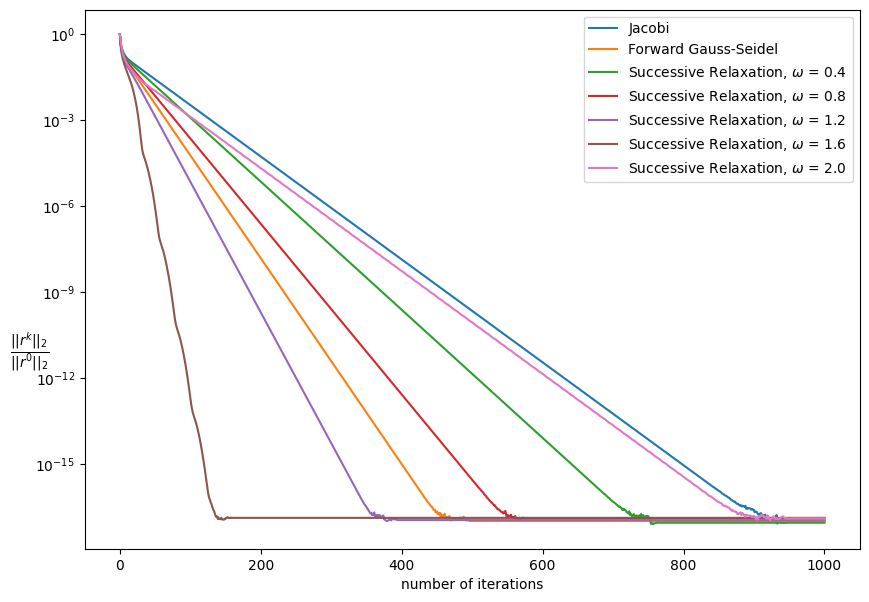

In [6]:
# Your code
from numpy.linalg import norm

def res(A, M, f, u0, maxIter = 50):
    
    # Pre-computing some variables to save some computation.
    dx = 1 / (nx +1)                                        
    x = [i*dx for i in range(1,nx+1)]                                         # {x_i} = {y_i}
    F = np.array([f(x[i],x[j]) for j in range(nx) for i in range(nx)])        # { f(x_i,y_j) | for i,j in 1,2,...,n }
    dxsqF = dx**2 * F                              
    
    Minv = inv(M)        
    N = M - A
    MinvN = Minv @ N
    B = Minv @ dxsqF

    # Iterates u and stores each iterative in u = []
    u = [] 
    u_k = np.copy(u0) 
    u.append(u_k)                                            
    for i in range(maxIter):                                        
        u_k = MinvN @ u_k + B
        u.append(u_k)

    r0norm = norm(dxsqF - A @ u[0])
    rknorm = [norm(dxsqF - A @ u) for u in u]
    return rknorm/r0norm

JacobiRes = res(A, Ad,f,u0,1000)
FGSRes = res(A, Ad-Al, f, u0,1000)

plt.figure(figsize=(10,7))
plt.plot(np.arange(len(JacobiRes)), JacobiRes, label = "Jacobi")
plt.plot(np.arange(len(FGSRes)), FGSRes, label = "Forward Gauss-Seidel")
for k in range(1,5+1):
    plt.plot(np.arange(1000+1), res(A,Ad-k*w*Al,f,u0,1000), label = fr"Successive Relaxation, $\omega$ = {round(k*w,2)}")
plt.yscale("log")
plt.legend(loc="best")
plt.ylabel(r"$\frac{||r^k||_2}{||r^0||_2}$",rotation=0,fontsize= 14,y=0.325)
plt.xlabel(r"number of iterations")
plt.show()

# 2 Chebyshev nodes
We are going to interpolate the function
$$
f(x)=\frac{\cos(x^3)}{1+13(x-1)^4}
$$
on the interval $[0,2]$.

1. Create a function that takes as inputs points $x_i,y_i,z_i$, and outputs the value of the interpolation polynomial, that interpolates $x_i,y_i$, in the points $z_i$.

In [7]:
# Implement the interpolation function

def interpolate(x,y,z):
    def basis(x, z): # Computes the image of the lagrange basis polynomials over Z.
        n = len(x) 
        l = []  
        for i in range(n): # Computes the image of the i-th lagrange basis polynomial over Z and stores it in in l as l[i].
            li = np.ones(len(z)) 
            for j in range(n): 
                if i is not j:
                    li = li*(z-x[j])/(x[i]-x[j])
            l.append(li)
        return l
    def lagrange(y, l): # Computes the image of the lagrange polynomial over Z.
        poly = 0
        for i in range(len(y)):
            poly += y[i]*l[i]
        return poly
    l = basis(x, z)
    return lagrange(y,l)


2. Interpolate the function $f(x)$ using both $n$ equidistant nodes, and with $n$ Chebyshev nodes, for $n=15,\dots,50$. Compute the maximal error for each interpolation. Plot the maximal error against $n$.

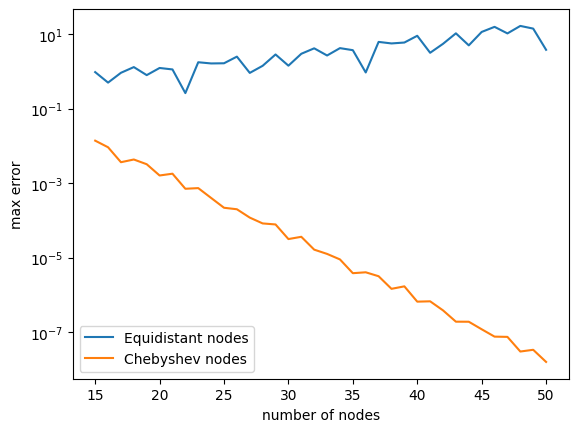

In [8]:
# Your code
from numpy import absolute as abs
def f(x):
    return np.cos(x**3)/(1+13*(x-1)**4)
def equinodes(n):                                                                   # Returns a list of n equidistant nodes between [0,2]
    return [((2*i)/n) for i in range(n+1)]
def chebnodes(n):                                                                   # Returns a list of n Chebyshev nodes between [0,2]
    return [(1 + np.cos((2*i-1)*np.pi/(2*n))) for i in range(1,n+1)]

# Lists for storing the maximal errors.
Lerror = []
Cerror = []

# Here we approximate the maximal error by finding the maximal difference between f and the interpolation polynomial in the thousand equidistant points between [0,2].  
x = np.linspace(0,2,1000)
fx = [f(x) for x in x]

n = np.arange(15,51)
for i in n:
    nodesEqui = equinodes(i)
    nodesCheb = chebnodes(i)
    pointsEqui = [f(x) for x in nodesEqui]
    pointsCheb = [f(x) for x in nodesCheb]
    Lerror.append(max(abs(fx - interpolate(nodesEqui,pointsEqui,x))))
    Cerror.append(max(abs(fx - interpolate(nodesCheb,pointsCheb,x))))

plt.plot(n,Lerror, label = "Equidistant nodes")
plt.plot(n,Cerror, label = "Chebyshev nodes")
plt.xlabel("number of nodes")
plt.ylabel("max error")
plt.yscale("log")
plt.legend()
plt.show()












# 3 Interpolation in Newton form

The Newton form of the interpolating polynomial $p_n$, that interpolates points $x_i,y_i$, is given by:
\begin{align*}
p_n(x)=&a_0+a_1(x-x_0)+a_2(x-x_0)(x-x_1)+\dots+a_n(x-x_0)\dots(x-x_{n-1})\\
=&\sum_{k=0}^{n-1}a_x\omega_k,
\end{align*}
where $\omega_k=\prod_{j=0}^{k-1}(x-x_j)$. The coefficients $a_k$ has to be determined from the interpolation points. The following method of determining the coefficients is called divided differenced. Define
\begin{align*}
[x_i]=&y_i,\\
[x_j,\dots,x_k]=&\frac{[x_{j+1},\dots,x_k] - [ x_j,\dots,x_{k-1} ]}{x_k-x_j},
\end{align*}
then the coefficients are
\begin{align*}
a_k=[x_0,\dots,x_k].
\end{align*}

1. Use induction to show that divided differences gives the correct coefficients for the interpolating polynomial. Conclude how the Newton form is useful to recursively add more interpolation points.

Let $\{(x_i,y_i)| i=0,1,...,n\}$ be the set of interpolation points. To show that divided differences gives the correct coefficients for the interpolating polynomial we show that $\forall n \ \forall i \ p_n(x_i) = y_i$ by induction.

Let $n=1$  
$$ \begin{align*}
p_1(x) &= a_0 + a_1(x-x_0) \\
p_1(x_0) &= a_0 + a_1(x_0 - x_0) = a_0 = y_0 \\
p_1(x_1) &= a_0 + \frac{y_1 - y_0}{x_1 - x_0}(x_1-x_0) = y_0 + y_1 - y_0 = y_1 \\
\end{align*}$$
n=1 ok.  

\
\
Assume n=k holds, i.e.,    

$\quad p_k(x_i) = y_i$ for i = 0,1,...,k   

\
\
For n=k+1   

We  start by splitting $p_{k+1}(x_i)$ into $p_k(x_i) + a_{k+1}w_{k+1}$ where $p_k$ is the k-th degree Newton polynomial that interpolates the first k+1 points $\{(x_i,y_i) \ | \ i = 0,1,...,k\}$  
$$ \begin{align*}
p_{k+1}(x_i) &= \sum_{j=0}^{k+1} a_jw_j(x_i) 
\\ &= \sum_{j=0}^{k} a_jw_j(x_i) + a_{k+1}w_{k+1}(x_i) 
\\ &= p_k(x_i) + a_{k+1}w_{k+1}(x_i) 
\end{align*}
$$

Now we consider two cases, i = 0,1,...,k and i = k+1

1. for i = 0,1,...,k    

    $p_k(x_i) = y_i$ by assumption and $w_{k+1}(x_i) = \prod_{j=0}^{k}(x_i - x_j) = (x_i-x_i) \prod_{j \neq i}^{k}(x_i - x_j) = 0\prod_{j\neq i}^{k}(x_i - x_j) = 0 
    $    
    
    Thus $p_{k+1}(x_i) = p_k(x_i) + a_{k+1}w_{k+1}(x_i) = y_i + a_{k+1}*0 = y_i $

2. for i = k+1

    We know that $p_{k+1}(x_{k+1}) =  \sum_{j=0}^{k+1} a_jw_j(x_{k+1}) = y_{k+1}$ holds if we can show that $a_{k+1}w_{k+1}(x_{k+1}) = y_{k+1} -  \sum_{j=0}^{k} a_jw_j(x_{k+1}) = y_{k+1} - p_k(x_{k+1})$ 

    Here we will use the expanded form of divided differences given by $[x_0,...,x_{k+1}] = \sum_{j=0}^{k+1} \frac{y_j}{\prod_{m \in \{0,1,...,k+1\} \setminus \{j\}} x_j - x_m } $

    Here we observe that 
    $$\begin{align*} 
    a_{k+1}w_{k+1}(x_{k+1}) &= [x_0,...,x_{k+1}]w_{k+1}(x_{k+1})
    \\ &= w_{k+1}(x_{k+1})\sum_{j=0}^{k+1} \frac{y_j}{\prod_{m \in \{0,1,...,k+1\} \setminus \{j\}} x_j - x_m }
    \\ &= y_{k+1}\frac{\prod_{m=0}^{k} x_{k+1} - x_m }{\prod_{m \in \{0,1,...,k+1\} \setminus \{k+1\}} x_{k+1} - x_m } + \sum_{j=0}^{k} y_j\frac{\prod_{m=0}^{k} x_{k+1} - x_m }{\prod_{m \in \{0,1,...,k+1\} \setminus \{j\}} x_j - x_m }
    \\ &= y_{k+1}\frac{\prod_{m=0}^{k} x_{k+1} - x_m }{\prod_{m=0}^{k} x_{k+1} - x_m } + \sum_{j=0}^{k} y_j \frac{(x_{k+1}-x_j)\prod_{m \in \{0,1,...,k\} \setminus \{j\}} x_{k+1} - x_m }{(x_j-x_{k+1})\prod_{m \in \{0,1,...,k\} \setminus \{j\}} x_j - x_m}
    \\ &= y_{k+1} + \sum_{j=0}^{k} (y_j)(-\prod_{\substack{m=0 \\ m\neq j}}^{k} \frac{x_{k+1}-x_m}{x_j-x_m})
    \\ &= y_{k+1} - \sum_{j=0}^{k} y_jl_j(x_{k+1}) \text{\quad where $l_j$ are the lagrange basis polynomials that interpolate the k nodes } \{ \ x_i \ | \ i=0,1,...,k\} 
    \\ &= y_{k+1} - L_k(x_{k+1}) \quad L_k \text{ the k-th degree Lagrange polynomial that interpolates } \ \{\ (x_i,y_i) \ | \ i=0,...,k\}
    \end{align*}
    $$
    By theorem 6.1, the k-th degree polynomial interpolating k+1 interpolation points $\{(x_i,y_i)| i=0,...,k\}$ is unique thus $L_k(x_{k+1}) = p_k(x_{k+1})$   
    
    Thus we get

    $ \begin{aligned} a_{k+1}w_{k+1}(x_{k+1}) &= y_{k+1} - L_k(x_{k+1}) 
        \\ &= y_{k+1} - p_k(x_{k+1}) \end{aligned}$ 
    
    Which completes the proof.
    

    

    ---
    
    A benefit of adding more points with the Newton form is that the all of the summands in the polynomial interpolating the initial set of points are used in the new polynomial. 
    Thus to compute the new higher dergee polynomial the amount of new summands that need to be computed is identical to the number of new points added.